In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterVector

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import optimizer to optimize the variational cirucit
from qiskit.aqua.components.optimizers import COBYLA

from qiskit import Aer

from qiskit.providers.aer import StatevectorSimulator

In [3]:
provider = IBMQ.load_account()

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()
num_qubits = 3


## Make the compressed XYZ gate a variational gate

In [5]:
# This is the compressed variational XYZ gate
def R_xyz_variational(theta):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*theta-np.pi/2, 0)
    t_qc.rz(2 * theta, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [6]:
theta = ParameterVector('theta', 4)
theta2 = ParameterVector('theta2', 4)

In [7]:
def get_var_form(theta):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for trotter_step in range(0, 4):
        for i in range(0, num_qubits - 1):
            Trot_qc.append(R_xyz_variational(theta[trotter_step]).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    # qc.measure(qr, [qr[1], qr[3], qr[5]])
    return qc, qr

In [8]:
def get_var_form_2(theta, theta2):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    # CNOTS between qubit 3&5 have less errors!
    Trot_qc.append(R_xyz_variational(theta2[0]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(theta2[0]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(theta2[1]+theta[1]+theta2[2]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    Trot_qc.append(R_xyz_variational(theta2[2]).to_instruction(), [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(R_xyz_variational(theta[3]+theta2[3]).to_instruction(), [Trot_qr[1], Trot_qr[2]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    return qc, qr

In [9]:
def objective_function_original_circuit(params):

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc, _ = get_var_form(theta)
    qc = qc.bind_parameters({theta: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

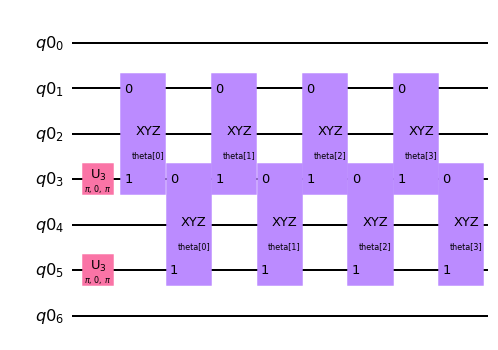

In [10]:
qc, _ = get_var_form(theta)
qc.decompose().draw('mpl')

In [11]:
# Optimize the circuit parameters
optimizer = COBYLA(maxiter=500, tol=0.0001)
#params = np.random.rand(5)
#params = np.zeros(5)

params = (np.pi/4)*np.ones(4)
ret = optimizer.optimize(num_vars=4, objective_function=objective_function_original_circuit, initial_point=params)

In [25]:
def objective_function_compressed_circuit(params):

    backend = Aer.get_backend('statevector_simulator')

    # put the x stuff as well

    qc, _ = get_var_form(ret[0])
    # qc = qc.bind_parameters({theta: params})
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc)

    qc, _ = get_var_form_2(ret[0], theta2)
    qc = qc.bind_parameters({theta2: params})
    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [26]:
# Optimize the parameters, such that the compressed circuit matches the original circuit
optimizer = COBYLA(maxiter=500, tol=0.0001)

params = (np.pi/4)*np.ones(4)
ret_2 = optimizer.optimize(num_vars=4, objective_function=objective_function_compressed_circuit, initial_point=params)

In [27]:
ret_2

(array([-9.04049819e-04,  1.97862787e+00,  1.17436446e-03,  1.74101825e+00]),
 1.8077320827480925e-05,
 62)

In [28]:
qc, qr = get_var_form_2(ret[0], ret_2[0])

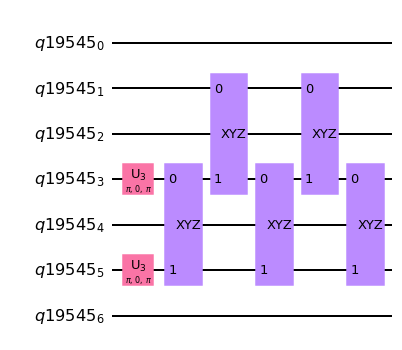

In [29]:
qc.decompose().draw('mpl')

In [30]:
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

In [31]:
shots = 8192
reps = 1
backend = sim_noisy_jakarta
# backend = Aer.get_backend('aer_simulator_statevector')
# reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 26edc5a4-a8bc-48a2-b602-898ab66d5bca


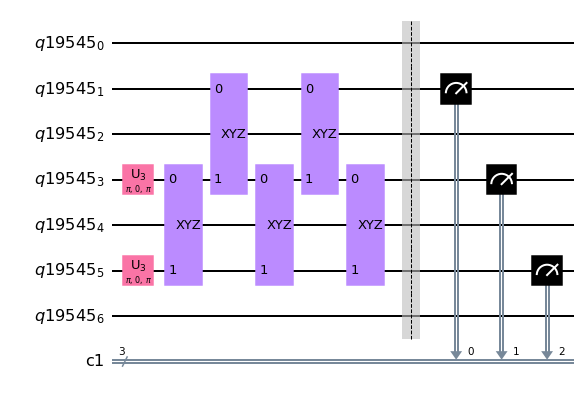

In [32]:
st_qcs[-1].decompose().draw(output="mpl") 

In [33]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7926 ± 0.0000


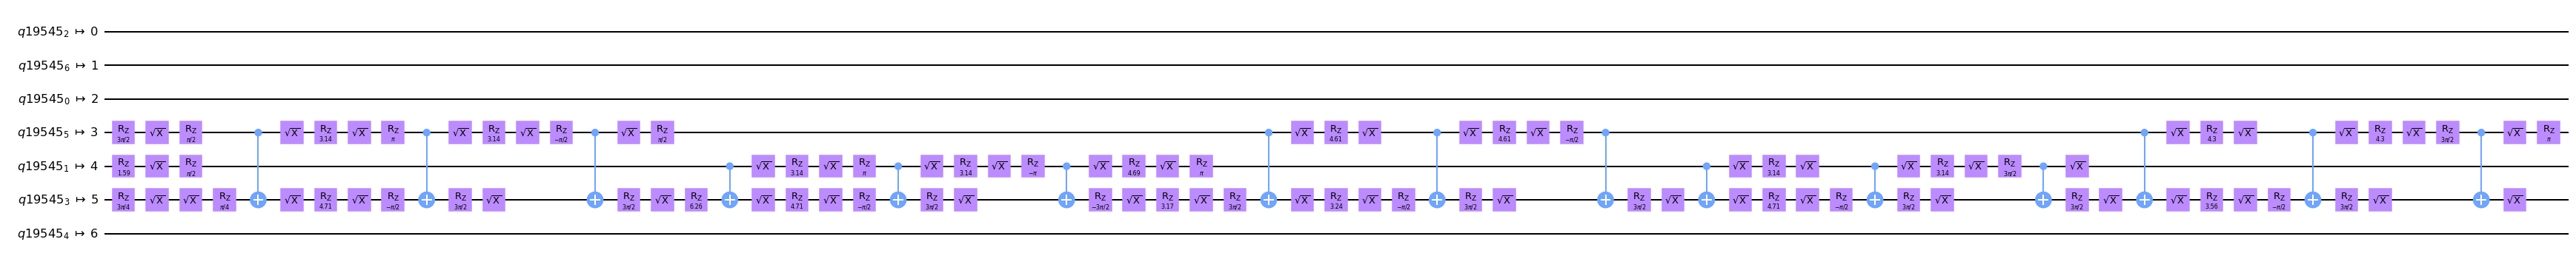

In [34]:
transpiled_qc = transpile(qc, optimization_level=3, backend=jakarta)
transpiled_qc.draw(output="mpl",fold=-1)

In [35]:
print('depth: {}, #cx: {}, #sx: {}'.format(transpiled_qc.depth(), transpiled_qc.count_ops()['cx'], transpiled_qc.count_ops()['sx']))

depth: 73, #cx: 15, #sx: 50
